# Random Forest Final Model - Mace Head, Ireland

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = config.site
site_name = config.site_dict[site]
assert site == 'MHD', 'This script is only for Mace Head, Ireland. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a random forest model for \033[1m{site_name}\033[0;0m.")

Creating a random forest model for Mace Head, Ireland.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_pca_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,flag
38920,2017-04-09 19:00:00,-4.023373,-0.275703,-1.934574,-0.853232,7.408166,0.551916,-2.046466,-0.305864,-0.406136,...,-0.311773,-0.441930,-0.392776,0.052966,1.216012,-0.138342,-1.191781,0.455074,-0.743114,1.0
32891,2012-11-25 05:00:00,1.887474,-3.263623,3.050905,-1.752534,2.215257,0.823395,2.478172,1.334063,1.454106,...,-4.287034,1.458375,1.793152,-0.056931,-0.106231,-3.053826,3.263669,0.927200,-0.849983,1.0
7271,1993-11-30 17:00:00,-1.345503,5.104684,3.883690,-5.251513,-4.280190,-3.485379,0.651248,1.025676,-0.294543,...,-0.378711,0.000745,0.820623,0.621545,2.460930,-0.734355,-1.575788,0.115063,1.713957,1.0
23637,2005-11-06 09:00:00,11.960782,-0.103321,3.496641,-2.537300,-1.541791,-0.611769,-2.945908,-1.961598,1.493466,...,1.532887,0.994195,1.188670,0.734330,-0.990912,-0.265022,0.424406,-0.167058,1.310327,1.0
27738,2008-10-25 05:00:00,7.708626,-0.973895,-10.804355,0.294451,-3.972029,1.207492,2.121402,-0.511478,0.804143,...,-0.619273,-0.174998,-0.819353,-1.470841,2.211068,0.894811,0.474746,-0.930375,1.503542,1.0


In [4]:
train_data = data[(data['time'].dt.year >= 2016) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2016-01-01 01:00:00 -> 2018-12-31 01:00:00. Length: 3991
Val range: 2019-01-04 05:00:00 -> 2019-12-30 13:00:00. Length: 1067
Test range: 2020-01-02 17:00:00 -> 2022-12-31 19:00:00. Length: 3985


### Model

In [5]:
# fitting models based on optimal hyperparameters

rf_model = RandomForestClassifier(random_state=42,
                                  n_estimators=100,
                                  max_depth=5,
                                  criterion='entropy',
                                  bootstrap=False,)

rf_model.fit(X_train, y_train)

class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = config.confidence_threshold

y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.957
Precision on Validation Set = 0.895
Recall on Training Set = 0.803
Recall on Validation Set = 0.726
F1 Score on Training Set = 0.873
F1 Score on Validation Set = 0.801


In [6]:
# evaluating the model on the test set

class_probabilities_test = rf_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_test:.3f}")

Precision on Test Set = 0.936
Recall on Test Set = 0.714
F1 Score on Test Set = 0.810


In [7]:
# saving model
dump(rf_model, data_path/f'rf_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\rf_model_MHD.joblib']

### Assessing Feature Importance

C:\Users\kirst\AppData\Local\Temp\ipykernel_4956\3156113180.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_importances.index)


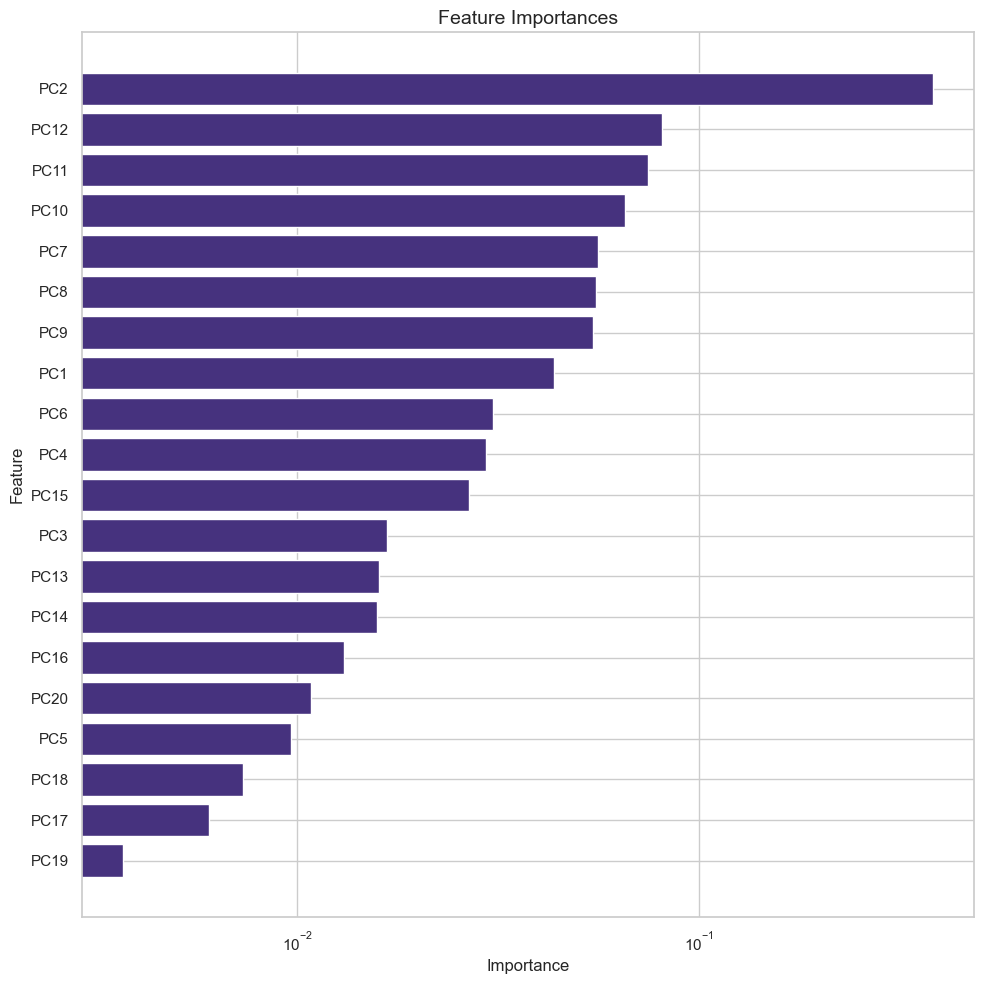

In [71]:
# finding most important features in the model

feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style='whitegrid')
sns.set_palette("viridis")

# sorting feature importances
feature_importances = feature_importances.sort_values('importance', ascending=True)

# bar chart of feature importances
ax.barh(feature_importances.index, feature_importances['importance'])

# making y axis logaritmic
ax.set_xscale('log')

ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances', fontsize=14)
ax.set_yticklabels(feature_importances.index)

fig.tight_layout()

In [67]:
# retrieving loadings from model setup
loadings = pd.read_csv(data_path/f'pca_loadings_{compound}_{site}.csv', index_col=0)
loadings

# extracting loadings of PCA2, 12 and 11
pca2 = loadings.iloc[:, 1]
pca12 = loadings.iloc[:, 11]
pca11 = loadings.iloc[:, 10]

# identifying features with the highest loadings in top 3 PCAs
pca2_features = pca2.abs().sort_values(ascending=False)
pca12_features = pca12.abs().sort_values(ascending=False)
pca11_features = pca11.abs().sort_values(ascending=False)

print(f"Top 5 features in PCA2: {pca2_features.head(3).index.values}")
print(f"Top 5 features in PCA12: {pca12_features.head(3).index.values}")
print(f"Top 5 features in PCA11: {pca11_features.head(3).index.values}")

Top 5 features in PCA2: ['u10_3' 'u10_0_past' 'u10_0']
Top 5 features in PCA12: ['v500_4_past' 'v500_3_past' 'u850_8']
Top 5 features in PCA11: ['v500_14' 'v500_14_past' 'v10_5_past']


In [70]:
# identifying what position importance blh is in for PCA2, 12 and 11
print(f"Position of 'blh' in PCA2: {pca2_features.index.get_loc('blh')}")
print(f"Position of 'blh' in PCA12: {pca12_features.index.get_loc('blh')}")
print(f"Position of 'blh' in PCA11: {pca11_features.index.get_loc('blh')}")

Position of 'blh' in PCA2: 27
Position of 'blh' in PCA12: 69
Position of 'blh' in PCA11: 49


Text(0.5, 1.02, 'Feature Importances for PCA Loadings')

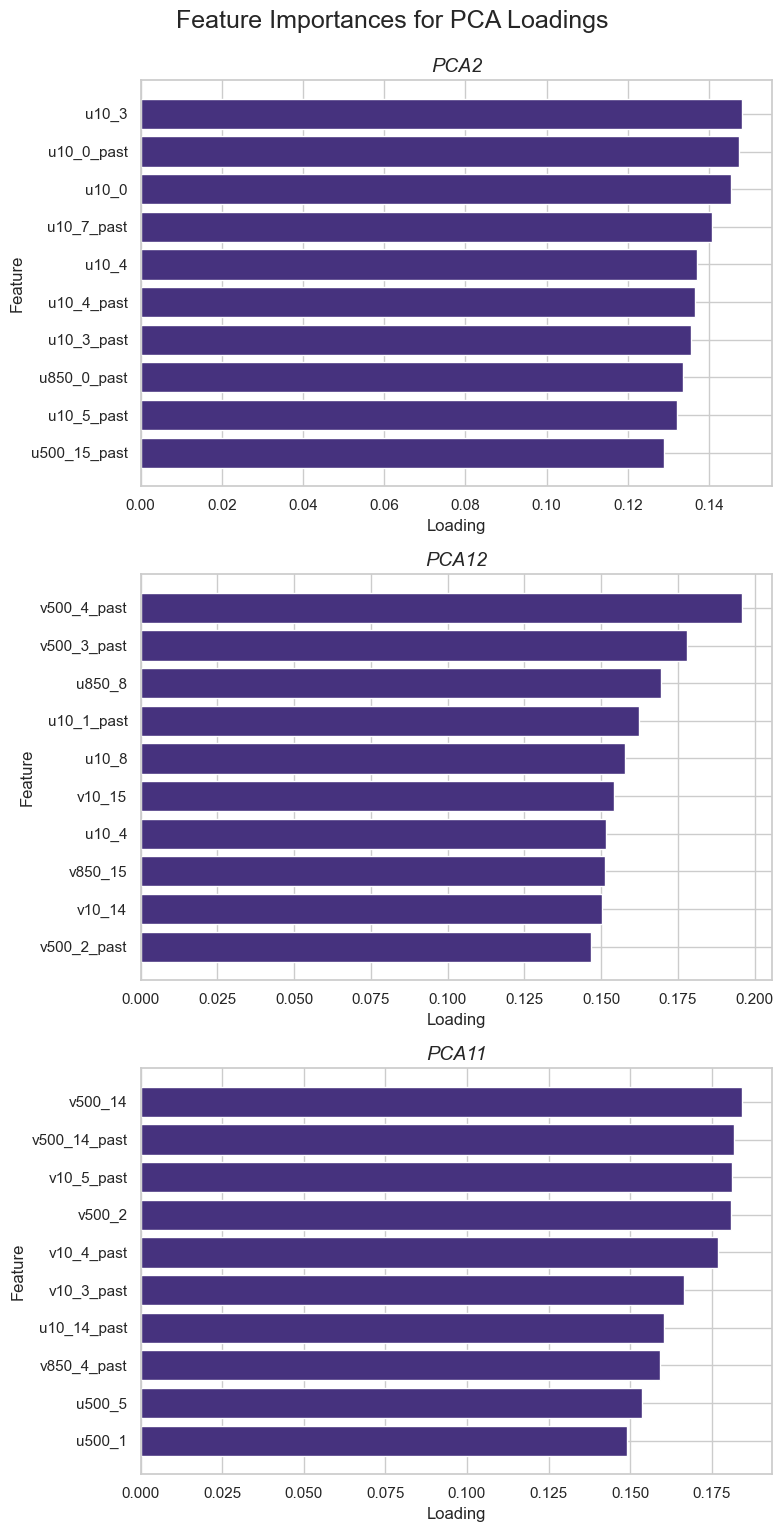

In [62]:
# plotting feature importances for loading of PCA2, 12 and 11
fig, axes = plt.subplots(3,1,figsize=(8, 15))
sns.set(style='whitegrid')
sns.set_palette("viridis")

# filtering feature importances for PCA2 - only including 10 most important features and sorting them
pca2_features = pca2_features.loc[pca2_features.index[:10]].sort_values(ascending=True)
pca12_features = pca12_features.loc[pca12_features.index[:10]].sort_values(ascending=True)
pca11_features = pca11_features.loc[pca11_features.index[:10]].sort_values(ascending=True)

# bar chart of feature importances
axes[0].barh(pca2_features.index, pca2_features)
axes[1].barh(pca12_features.index, pca12_features)
axes[2].barh(pca11_features.index, pca11_features)

# adding titles and labels
axes[0].set_ylabel('Feature')
axes[0].set_xlabel('Loading')
axes[0].set_title('PCA2', fontsize=14, fontstyle='italic')

axes[1].set_ylabel('Feature')
axes[1].set_xlabel('Loading')
axes[1].set_title('PCA12', fontsize=14, fontstyle='italic')

axes[2].set_ylabel('Feature')
axes[2].set_xlabel('Loading')
axes[2].set_title('PCA11', fontsize=14, fontstyle='italic')

fig.tight_layout()
fig.suptitle('Feature Importances for PCA Loadings', fontsize=18, y=1.02)